In [2]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import warnings
import math
import numpy as np
import seaborn as sns
from glob import glob
from scipy.optimize import curve_fit
import logging

In [3]:
# Load data

measurement_dirs = []
# measurement_dirs += glob(f"data/2024-06-17_21*/*/*/*")
# measurement_dirs += glob(f"data/2024-06-18*/*/*/*")
measurement_dirs += glob(f"data/2024-06-21*/*/*/*")
measurement_dirs += glob(f"data/2024-06-22*/*/*/*")
# measurement_dirs += glob(f"data_scale/*/*")
# measurement_dirs += glob(f"data_scale_rampup/*/*")

measurement_dirs = sorted(measurement_dirs)
display(measurement_dirs)

['data/2024-06-21_18-22-58/exp_scale_fixed/baseline_vanilla_full/0',
 'data/2024-06-21_18-22-58/exp_scale_fixed/dbopt_feature_db-optimization_full/0',
 'data/2024-06-21_18-22-58/exp_scale_fixed/jvm_jvm-impoove_full/0',
 'data/2024-06-21_18-22-58/exp_scale_fixed/norec_feature_norecommendations_full/0',
 'data/2024-06-21_18-22-58/exp_scale_fixed/obs_feature_object-storage_full/0',
 'data/2024-06-21_18-22-58/exp_scale_pausing/baseline_vanilla_full/0',
 'data/2024-06-21_18-22-58/exp_scale_pausing/dbopt_feature_db-optimization_full/0',
 'data/2024-06-21_18-22-58/exp_scale_pausing/jvm_jvm-impoove_full/0',
 'data/2024-06-21_18-22-58/exp_scale_pausing/norec_feature_norecommendations_full/0',
 'data/2024-06-21_18-22-58/exp_scale_pausing/obs_feature_object-storage_full/0',
 'data/2024-06-21_18-22-58/exp_scale_rampup/baseline_vanilla_full/0',
 'data/2024-06-21_18-22-58/exp_scale_rampup/dbopt_feature_db-optimization_full/0',
 'data/2024-06-21_18-22-58/exp_scale_rampup/jvm_jvm-impoove_full/0',
 'da

In [4]:
experiment_metadata = []

physical_nodes = ["sm-gpu","ise-knode6"]
cpu_specs = {
    #idle, peak, memory
    "sm-gpu":[20,90,2.5], #based on https://www.tomshardware.com/reviews/amd-ryzen-5-3600-review,6287-3.html
    "ise-knode6":[11,73,2.5] # based on https://www.tomshardware.com/reviews/skylake-intel-core-i7-6700k-core-i5-6600k,4252-11.html
}


node_models = {
    "sm-gpu":[45.92820512,56.31438933,-7.39335927],
    "ise-knode6":[41.25204258,42.25050137,22.34559982],
}

def energy_func(X, idle, c_peak, mem_peak):
    return idle + ((c_peak-idle) * X[:, 0]) + ((mem_peak) * X[:, 1])

def model_energy_funct(df:pd.DataFrame):
    for instance in node_models:
        df.loc[df["instance"]==instance,"wattage_estimation"] = energy_func(df[df["instance"]==instance][['cpu_usage', 'memory_usage']].values,*node_models[instance])
    return df

from scipy.stats import zscore
def measurment_processor(df:pd.DataFrame, z_score_threshold: float = 4, drop_unknown_instance:bool=True):
    data_errors = 0
    data_size = len(df)

    #print(f'{len(df[df["collection_time"] == "0"])} timeoffs')
    data_errors += len(df[df["collection_time"] == "0"])

    #time alignment - map data time to experiment time to get a relative score
    df = df.drop(df[df["collection_time"] == "0"].index)
    df["collection_time"] = pd.to_datetime(df["collection_time"],format="mixed")
    df["run_time"] = (df["collection_time"] - df["collection_time"].min())
    df["run_time"] = df["run_time"].apply(lambda x:int(x.total_seconds()))
    
    
    #quality control (check if we have unknown data points (thats and issue), z-scroe > threshold) and remove
    instance_issues = df[df["instance"] == "unknown"].index
    data_errors += len(instance_issues)
    
    if drop_unknown_instance:
        #print(f"dropped {len(instance_issues)} unknowns")
        df = df.drop(instance_issues)

    #calculate z-scores
    common_keys = ["wattage_kepler","wattage_scaph","cpu_usage","memory_usage","network_usage"]
    for key in common_keys:
        df[f"{key}_zscore"]  = zscore(df[key])


    for key in common_keys:
        outliers = df[df[f"{key}_zscore"].abs() > z_score_threshold].index
        #print(f"{len(outliers)} zScore")
        data_errors += len(outliers)
        df = df.drop(outliers)

    df = model_energy_funct(df)

    experiment_metadata.append(
        list(df[["exp_workload","exp_branch","exp_run_i","exp_time","exp_run","exp_scaler","run"]].iloc[0].values) + [len(df),data_errors]
    )

    return df, (data_errors/data_size)

def exp_file_to_df(file:str, prefix: str) -> pd.DataFrame:
    (pr_time,pr_scale, pr_branch, pr_run, pr_name) = "/".join(file.split("/")[-5:]).split("/")
    pod_df = pd.read_csv(file)
    pod_df["exp_workload"] = pr_scale
    pod_df["exp_branch"] = pr_branch
    pod_df["exp_run_i"] = pr_run
    pod_df["exp_time"] = pr_time
    
    run_name = pr_name.replace(prefix, "").replace(".csv", "")
    scaler = pr_branch.split("_")[-1]

    pod_df["exp_run"] = run_name
    pod_df["exp_scaler"] = scaler

    pod_df["run"] = "_".join([pr_branch, pr_scale, pr_run])

    return pod_df

def measurement_file_to_df(file:str, df:pd.DataFrame, quality_control=True, quality_warning=0.1, quality_error=0.25):
    # no risk, no fun
    if quality_control:
        df, error_rate = measurment_processor(df)
        if error_rate > quality_error:
            raise ValueError(f"{file} contains {int(error_rate*100)}% fauly measurments (z-score, unknowns, 0-time...)")
        if error_rate > quality_warning:
            logging.warning(f"{file} contains quality issues, droped: {int(error_rate*100)}% of measurments")
    else:
         df, _ = measurment_processor(df,z_score_threshold=10, drop_unknown_instance=False)
    
    return df


def get_df_for_prefix(prefix, measurement_dirs, quality_control=True, quality_threshold=0.25, fail_on_quality_error=True):
    pod_files = np.concatenate([glob(f"{d}/{prefix}*") for d in measurement_dirs])
    
    def loader(f):
        try:
            return measurement_file_to_df(f,exp_file_to_df(f, prefix), quality_control=quality_control, quality_error=quality_threshold)
        except ValueError as e:
            if fail_on_quality_error:
                raise e
            else:
                logging.error(f"{f} contains >= {int(quality_threshold*100)}% fauly measurments (z-score, unknowns, 0-time...), droping the measurment")
                return None
        
    all_pods = pd.concat([loader(pf) for pf in pod_files])
    return all_pods

def get_stats_df_for_prefix(prefix:str, measurement_dirs:str):
    stat_files = np.concatenate([glob(f"{d}/{prefix}*") for d in measurement_dirs])
    all_stats = pd.concat([exp_file_to_df(pf,prefix) for pf in stat_files])
    #renamte colums to lowercase and without spaces
    all_stats.columns = list(map(lambda x:x.lower().replace(" ","_"),all_stats.columns.values))
    return all_stats[all_stats["name"]!= "Aggregated"]


In [5]:
all_nodes = get_df_for_prefix("measurements_node_", measurement_dirs)
all_nodes

,instance,observation_time,collection_time,cpu_usage,memory_usage,network_usage,wattage,num_processes,wattage_kepler,wattage_scaph,...,exp_run,exp_scaler,run,run_time,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,wattage_estimation
0,sm-gpu,2024-06-21 20:59:55,2024-06-21 20:59:55,0.414763,0.135156,0.071736,47,12,0.478200,16.930880,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,-0.065215,1.440066,0.219216,-0.837928,-0.320866,49.236759
1,ise-kmaster,2024-06-21 20:59:55,2024-06-21 20:59:55,0.219377,0.241342,0.337807,0,10,0.000000,0.000000,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,-0.632276,-0.705155,-0.225942,0.788169,-0.236853,NaN
2,ise-knode2,2024-06-21 20:59:55,2024-06-21 20:59:55,0.078333,0.215238,0.009853,0,5,0.000000,0.000000,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,-0.632276,-0.705155,-0.547290,0.388414,-0.340406,NaN
4,ise-knode3,2024-06-21 20:59:55,2024-06-21 20:59:55,0.036667,0.129553,0.012723,0,5,0.000000,0.000000,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,-0.632276,-0.705155,-0.642222,-0.923723,-0.339499,NaN
5,ise-knode6,2024-06-21 20:59:55,2024-06-21 20:59:55,0.207667,0.094686,0.489821,43,17,2.140719,15.343599,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,1.906240,1.238950,-0.252623,-1.457667,-0.188853,43.575207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,ise-knode1,2024-06-22 14:47:30,2024-06-22 14:47:30,0.289000,0.190135,0.694416,0,15,0.087300,0.108896,...,22_06_2024_14_41,full,obs_feature_object-storage_full_exp_scale_shap...,343,-0.512882,-0.693736,0.220497,0.337407,0.629122,NaN
206,ise-knode2,2024-06-22 14:47:30,2024-06-22 14:47:30,0.052000,0.217170,0.158973,0,5,0.000000,0.000000,...,22_06_2024_14_41,full,obs_feature_object-storage_full_exp_scale_shap...,343,-0.621765,-0.707722,-0.942263,0.869496,-0.986351,NaN
207,sm-gpu,2024-06-22 14:47:30,2024-06-22 14:47:30,0.234000,0.178092,0.298472,46,13,0.273333,15.368711,...,22_06_2024_14_41,full,obs_feature_object-storage_full_exp_scale_shap...,343,-0.280856,1.266119,-0.049342,0.100381,-0.565473,47.041877
208,ise-kmaster,2024-06-22 14:47:30,2024-06-22 14:47:30,0.214667,0.243522,0.342906,0,10,0.000000,0.000000,...,22_06_2024_14_41,full,obs_feature_object-storage_full_exp_scale_shap...,343,-0.621765,-0.707722,-0.144194,1.388125,-0.431412,NaN


In [6]:
# get all pod measurements
experiment_metadata = []
logging.getLogger().setLevel(logging.ERROR)
all_pods = get_df_for_prefix("measurements_pod_", measurement_dirs, fail_on_quality_error=False)
all_pods["instance"].unique()

ERROR:root:data/2024-06-21_18-22-58/exp_scale_pausing/baseline_vanilla_full/0/measurements_pod_21_06_2024_20_52.csv contains >= 25% fauly measurments (z-score, unknowns, 0-time...), droping the measurment
ERROR:root:data/2024-06-21_18-22-58/exp_scale_pausing/dbopt_feature_db-optimization_full/0/measurements_pod_21_06_2024_18_44.csv contains >= 25% fauly measurments (z-score, unknowns, 0-time...), droping the measurment
ERROR:root:data/2024-06-21_18-22-58/exp_scale_pausing/jvm_jvm-impoove_full/0/measurements_pod_21_06_2024_20_20.csv contains >= 25% fauly measurments (z-score, unknowns, 0-time...), droping the measurment
ERROR:root:data/2024-06-21_18-22-58/exp_scale_pausing/norec_feature_norecommendations_full/0/measurements_pod_21_06_2024_19_17.csv contains >= 25% fauly measurments (z-score, unknowns, 0-time...), droping the measurment
ERROR:root:data/2024-06-22_11-26-02/exp_scale_fixed/dbopt_feature_db-optimization_full/1/measurements_pod_22_06_2024_12_23.csv contains >= 25% fauly meas

array(['ise-knode1', 'sm-gpu', 'ise-knode6'], dtype=object)

In [7]:
metadata =  pd.DataFrame(experiment_metadata, columns=["exp_workload","exp_branch","exp_run_i","exp_time","exp_run","exp_scaler","run","elements","error"])
metadata

,exp_workload,exp_branch,exp_run_i,exp_time,exp_run,exp_scaler,run,elements,error
0,exp_scale_fixed,baseline_vanilla_full,0,2024-06-21_18-22-58,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,291,51
1,exp_scale_fixed,dbopt_feature_db-optimization_full,0,2024-06-21_18-22-58,21_06_2024_18_51,full,dbopt_feature_db-optimization_full_exp_scale_f...,349,69
2,exp_scale_fixed,jvm_jvm-impoove_full,0,2024-06-21_18-22-58,21_06_2024_20_27,full,jvm_jvm-impoove_full_exp_scale_fixed_0,287,49
3,exp_scale_fixed,norec_feature_norecommendations_full,0,2024-06-21_18-22-58,21_06_2024_19_24,full,norec_feature_norecommendations_full_exp_scale...,305,68
4,exp_scale_fixed,obs_feature_object-storage_full,0,2024-06-21_18-22-58,21_06_2024_19_55,full,obs_feature_object-storage_full_exp_scale_fixed_0,290,70
...,...,...,...,...,...,...,...,...,...
63,exp_scale_shaped,lessrec_feature_lessrecs_full,1,2024-06-22_11-26-02,22_06_2024_12_40,full,lessrec_feature_lessrecs_full_exp_scale_shaped_1,261,75
64,exp_scale_shaped,norec_feature_norecommendations_full,0,2024-06-22_11-26-02,22_06_2024_13_33,full,norec_feature_norecommendations_full_exp_scale...,261,60
65,exp_scale_shaped,norec_feature_norecommendations_full,1,2024-06-22_11-26-02,22_06_2024_13_40,full,norec_feature_norecommendations_full_exp_scale...,230,70
66,exp_scale_shaped,obs_feature_object-storage_full,0,2024-06-22_11-26-02,22_06_2024_14_34,full,obs_feature_object-storage_full_exp_scale_shap...,234,56


In [8]:
all_pods

,collection_time,observation_time,name,namespace,cpu_usage,memory_usage,network_usage,instance,wattage_kepler,wattage_scaph,...,exp_run,exp_scaler,run,run_time,wattage_kepler_zscore,wattage_scaph_zscore,cpu_usage_zscore,memory_usage_zscore,network_usage_zscore,wattage_estimation
0,2024-06-21 20:59:55,2024-06-21 20:59:55,teastore-image-0,tea-bench,0.000000,1182.617600,0.000000,ise-knode1,34.6,0.045967,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,-0.759361,-0.119487,-0.441100,0.541982,-0.139151,NaN
1,2024-06-21 20:59:55,2024-06-21 20:59:55,teastore-db-0,tea-bench,0.000000,104.140800,0.000000,ise-knode1,17.3,0.000223,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,-0.835225,-0.255815,-0.441100,-1.624330,-0.139151,NaN
3,2024-06-21 20:59:55,2024-06-21 20:59:55,teastore-auth-0,tea-bench,0.000000,952.352768,0.000000,ise-knode1,34.6,0.023350,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,-0.759361,-0.186891,-0.441100,0.079455,-0.139151,NaN
5,2024-06-21 20:59:55,2024-06-21 20:59:55,teastore-persistence-0,tea-bench,0.000000,681.975808,0.000000,sm-gpu,472.8,0.183739,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,1.162237,0.291106,-0.441100,-0.463645,-0.139151,-4996.163957
6,2024-06-21 20:59:55,2024-06-21 20:59:55,teastore-registry-0,tea-bench,0.000000,273.612800,0.000000,sm-gpu,472.8,0.038161,...,21_06_2024_20_59,full,baseline_vanilla_full_exp_scale_fixed_0,0,1.162237,-0.142750,-0.441100,-1.283915,-0.139151,-1976.989526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2024-06-22 14:47:31,2024-06-22 14:47:30,teastore-persistence-0,tea-bench,0.051207,888.709120,0.023293,ise-knode1,10.8,0.000280,...,22_06_2024_14_41,full,obs_feature_object-storage_full_exp_scale_shap...,344,-1.064745,-0.413233,-0.168514,0.398556,-0.143364,NaN
276,2024-06-22 14:47:31,2024-06-22 14:47:30,teastore-db-0,tea-bench,0.001043,105.791488,0.006866,sm-gpu,205.3,0.001282,...,22_06_2024_14_41,full,obs_feature_object-storage_full_exp_scale_shap...,344,-0.145861,-0.408473,-0.581223,-1.046201,-0.387302,-736.215441
277,2024-06-22 14:47:31,2024-06-22 14:47:30,teastore-webui-0,tea-bench,0.086524,1781.313536,0.072345,sm-gpu,410.6,0.080791,...,22_06_2024_14_41,full,obs_feature_object-storage_full_exp_scale_shap...,344,0.824046,-0.031058,0.122046,2.045723,0.585077,-13123.064088
278,2024-06-22 14:47:31,2024-06-22 14:47:30,teastore-image-0,tea-bench,0.001939,95.666176,0.000000,ise-knode1,5.4,0.000014,...,22_06_2024_14_41,full,obs_feature_object-storage_full_exp_scale_shap...,344,-1.090256,-0.414495,-0.573848,-1.064885,-0.489265,NaN


In [9]:
all_stats = get_stats_df_for_prefix("teastore_stats.csv", measurement_dirs)
#filter only stats where we have pod info for
all_stats = all_stats[all_stats["run"].isin(all_pods["run"].unique())]

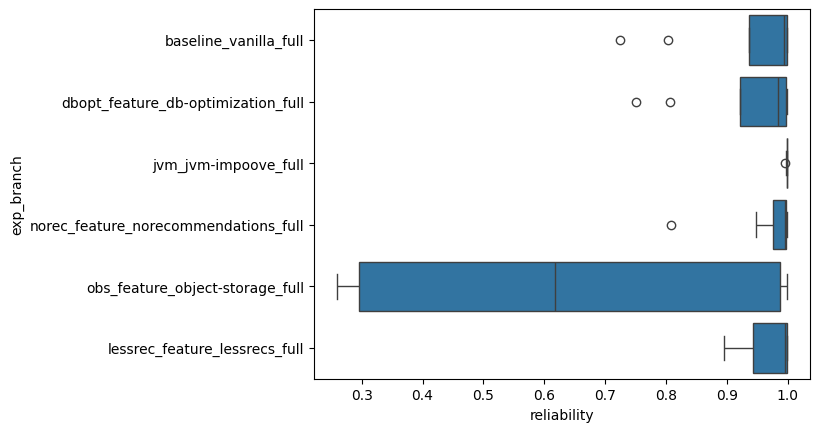

In [10]:

reliability = all_stats.groupby(["exp_time","exp_branch","exp_workload","exp_run_i"])[["request_count","failure_count"]].sum().reset_index()
reliability["reliability"]=1-reliability["failure_count"]/reliability["request_count"]

data = reliability
sns.boxplot(data=reliability,x="reliability",y="exp_branch")

exp_runtime = all_pods.groupby(["exp_time","exp_branch","exp_workload","exp_run_i"])["run_time"].max().reset_index()

reliability = pd.merge(reliability,exp_runtime, on=["exp_time","exp_branch","exp_workload","exp_run_i"], how="inner")
reliability["request_per_s"] = reliability["request_count"]/reliability["run_time"]

<Axes: xlabel='request_per_s', ylabel='exp_branch'>

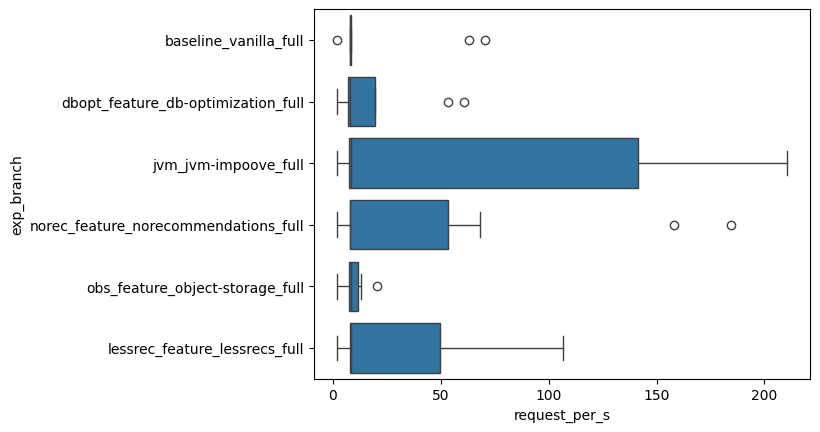

In [11]:
sns.boxplot(data=reliability,y="exp_branch",x="request_per_s")

In [12]:
metadata = metadata.merge(all_stats.groupby(["run"])[["request_count","failure_count"]].sum().reset_index(),on="run")
metadata["data_error_rate"] = metadata["error"]/metadata["elements"]
metadata["workload_error_rate"] = metadata["failure_count"]/metadata["request_count"]


In [13]:
agg_metadata = metadata.groupby(["exp_workload","exp_branch"])[["elements","error","request_count","failure_count"]].sum().reset_index()
agg_metadata["data_error_rate"] = agg_metadata["error"]/agg_metadata["elements"]
agg_metadata["workload_error_rate"] = agg_metadata["failure_count"]/agg_metadata["request_count"]

<Axes: xlabel='data_error_rate', ylabel='exp_workload'>

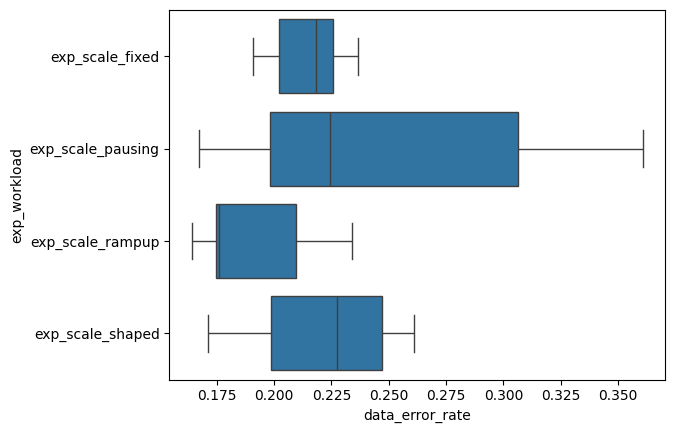

In [14]:
sns.boxplot(data=agg_metadata,y="exp_workload",x="data_error_rate")

<Axes: xlabel='workload_error_rate', ylabel='exp_branch'>

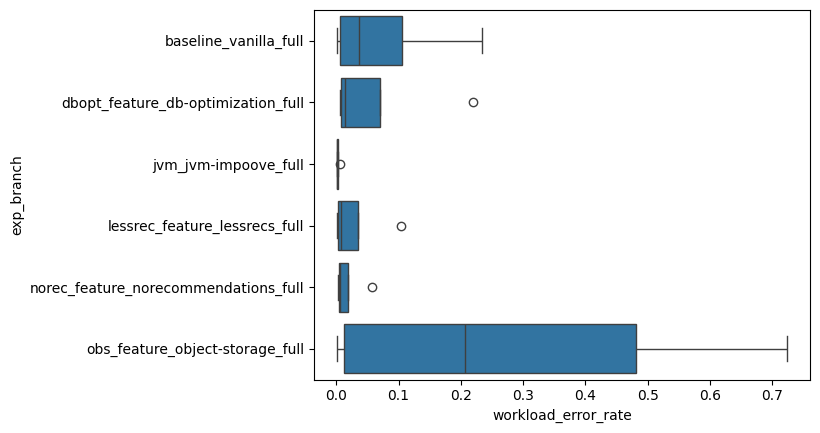

In [15]:
sns.boxplot(data=agg_metadata,y="exp_branch",x="workload_error_rate")

<Axes: xlabel='workload_error_rate', ylabel='exp_workload'>

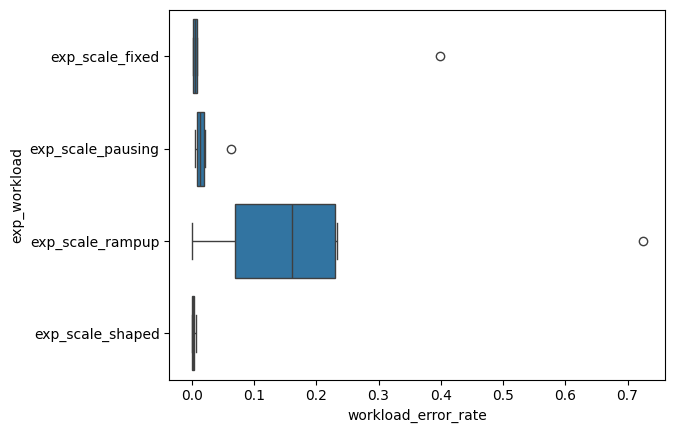

In [16]:
sns.boxplot(data=agg_metadata,y="exp_workload",x="workload_error_rate")

In [17]:
metadata[["run","exp_branch","workload_error_rate","data_error_rate"]].sort_values(by=["exp_branch","data_error_rate","workload_error_rate"])

,run,exp_branch,workload_error_rate,data_error_rate
7,baseline_vanilla_full_exp_scale_rampup_0,baseline_vanilla_full,0.233899,0.150142
0,baseline_vanilla_full_exp_scale_fixed_0,baseline_vanilla_full,0.008654,0.175258
18,baseline_vanilla_full_exp_scale_fixed_1,baseline_vanilla_full,0.005400,0.179402
44,baseline_vanilla_full_exp_scale_shaped_1,baseline_vanilla_full,0.000710,0.206897
27,baseline_vanilla_full_exp_scale_pausing_1,baseline_vanilla_full,0.063467,0.207018
33,baseline_vanilla_full_exp_scale_rampup_0,baseline_vanilla_full,0.233899,0.209790
12,baseline_vanilla_full_exp_scale_shaped_0,baseline_vanilla_full,0.000699,0.243590
43,baseline_vanilla_full_exp_scale_shaped_0,baseline_vanilla_full,0.000699,0.243590
17,baseline_vanilla_full_exp_scale_fixed_0,baseline_vanilla_full,0.008654,0.293233
28,dbopt_feature_db-optimization_full_exp_scale_p...,dbopt_feature_db-optimization_full,0.020619,0.167123


In [18]:


model_data = all_nodes[all_nodes["instance"].isin(physical_nodes)].groupby(["collection_time","instance"])[["num_processes","cpu_usage","memory_usage","network_usage","wattage","wattage_kepler","wattage_scaph","wattage_auxilary","wattage_estimation"]].sum()

model_data_pods = all_pods[all_pods["instance"].isin(physical_nodes)].groupby(["collection_time","instance"])[["wattage_kepler","wattage_scaph"]].sum().rename(columns={"wattage_kepler":"wattage_kepler_pods","wattage_scaph":"wattage_scaph_pods"})

model_data = model_data.join(model_data_pods) #model_data.merge(model_data_pods, left_index=True, right_on=["collection_time","instance"])

model_data["wattage_scaph_total"] = model_data["wattage_scaph"]+model_data["wattage_auxilary"]#+model_data["wattage_scaph_pods"]
model_data["wattage_kepler_total"] = model_data["wattage_kepler"]#+model_data["wattage_kepler_pods"]


model_data.reset_index(inplace=True)
for node in physical_nodes:
    display(node,model_data[model_data["instance"] == node][["wattage","wattage_scaph_total","wattage_kepler_total","wattage_estimation"]].corr())
display(model_data.groupby(["instance"])[["wattage","wattage_scaph_total","wattage_kepler_total","wattage_estimation"]].agg(["mean","min","max","std"]))

#build regression model based on sample
model_data = model_data.sample(1000)
for node in physical_nodes:

    y = model_data[model_data["instance"]==node]['wattage'].values
    X = model_data[model_data["instance"]==node][['cpu_usage', 'memory_usage']].values



    # Initial guess for the parameters (intercept and coefficients)
    initial_guess = cpu_specs[node]

    # Use curve_fit to fit the model
    params, covariance = curve_fit(energy_func, X, y, p0=initial_guess)

    # Extract the parameters
    # intercept, coef_cpu, coef_memory, coef_network = params
    display(f"{node} - {params}")



'sm-gpu'

,wattage,wattage_scaph_total,wattage_kepler_total,wattage_estimation
wattage,1.000000,0.629692,0.679103,0.789547
wattage_scaph_total,0.629692,1.000000,0.847174,0.749149
wattage_kepler_total,0.679103,0.847174,1.000000,0.830057
wattage_estimation,0.789547,0.749149,0.830057,1.000000


'ise-knode6'

,wattage,wattage_scaph_total,wattage_kepler_total,wattage_estimation
wattage,1.000000,0.494120,0.671229,0.659156
wattage_scaph_total,0.494120,1.000000,0.656183,0.657867
wattage_kepler_total,0.671229,0.656183,1.000000,0.896293
wattage_estimation,0.659156,0.657867,0.896293,1.000000


wattage                   wattage_scaph_total                  \
                 mean min max       std                mean  min        max   
instance                                                                      
ise-knode6  43.915008  43  54  1.213360           15.840244  0.0  21.287899   
sm-gpu      51.443142  41  78  7.161876           18.347075  0.0  30.918854   

                     wattage_kepler_total                                \
                 std                 mean       min       max       std   
instance                                                                  
ise-knode6  1.099960             2.488526  0.000000  5.568733  0.655407   
sm-gpu      3.845128             0.852484  0.076467  3.290933  0.681722   

           wattage_estimation                                  
                         mean        min        max       std  
instance                                                       
ise-knode6          43.854491  43.539197  47.451531  0.712646  
sm-gpu              51.236750  45.960803  73.751628  5.630253

'sm-gpu - [44.09155508 54.43929108  4.51856544]'

'ise-knode6 - [41.52115158 42.77764093 19.20003683]'

<Axes: xlabel='wattage_scaph', ylabel='cpu_usage'>

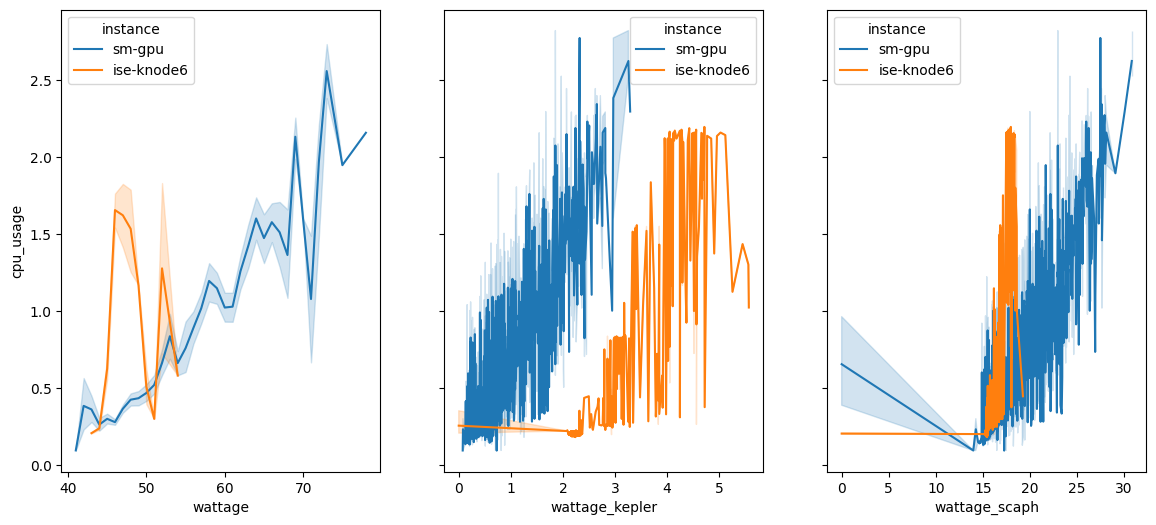

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
sns.lineplot(all_nodes[all_nodes["instance"].isin(physical_nodes)],x="wattage",y="cpu_usage",hue="instance",ax=axs[0])
sns.lineplot(all_nodes[all_nodes["instance"].isin(physical_nodes)],x="wattage_kepler",y="cpu_usage",hue="instance",ax=axs[1])
sns.lineplot(all_nodes[all_nodes["instance"].isin(physical_nodes)],x="wattage_scaph",y="cpu_usage",hue="instance",ax=axs[2])
# sns.lineplot(all_nodes[all_nodes["instance"].isin(physical_nodes)],x="wattage",y="cpu_usage",hue="instance",ax=axs[0])
# sns.lineplot(all_nodes[all_nodes["instance"].isin(physical_nodes)],x="wattage_estimation",y="cpu_usage",hue="instance",ax=axs[1])

In [11]:
def comparision_plot(data, y_label, exp_branch):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    sns.lineplot(data=data[data["exp_branch"]==exp_branch],x="exp_time",y=y_label,ax=axs[0])
    axs[0].set_title(exp_branch)
    sns.lineplot(data=data[data["exp_branch"]=="baseline_vanilla_full"],x="exp_time",y=y_label,ax=axs[1])
    axs[1].set_title("baseline")
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    

In [12]:
exp_runtime = all_pods.groupby(["exp_time","exp_branch","exp_workload","exp_run_i"])["run_time"].max().reset_index()
requests = all_stats.groupby(["exp_time","exp_branch","exp_workload","exp_run_i"])[["request_count","failure_count"]].sum().reset_index()
requests = pd.merge(requests,exp_runtime, on=["exp_time","exp_branch","exp_workload","exp_run_i"], how="inner")
requests["real_requests"]=requests["request_count"]-requests["failure_count"]
requests["request_per_s"] = requests["real_requests"]/requests["run_time"]
requests.groupby(["exp_branch","exp_workload"])[["real_requests","request_per_s"]].sum()

real_requests  \
exp_branch                           exp_workload                       
baseline_vanilla_full                exp_scale_fixed             8491   
                                     exp_scale_pausing            605   
                                     exp_scale_rampup           36222   
                                     exp_scale_shaped            8531   
dbopt_feature_db-optimization_full   exp_scale_fixed             5656   
                                     exp_scale_pausing            665   
                                     exp_scale_rampup           31503   
                                     exp_scale_shaped            7458   
jvm_jvm-impoove_full                 exp_scale_fixed             8261   
                                     exp_scale_pausing            759   
                                     exp_scale_rampup          207035   
                                     exp_scale_shaped            8720   
lessrec_feature_lessrecs_full        exp_scale_fixed             5822   
                                     exp_scale_pausing            780   
                                     exp_scale_rampup           62777   
                                     exp_scale_shaped            5619   
norec_feature_norecommendations_full exp_scale_fixed             8392   
                                     exp_scale_pausing            756   
                                     exp_scale_rampup          135547   
                                     exp_scale_shaped            8279   
obs_feature_object-storage_full      exp_scale_fixed             3279   
                                     exp_scale_pausing           1503   
                                     exp_scale_rampup            4387   
                                     exp_scale_shaped            5810   

                                                        request_per_s  
exp_branch                           exp_workload                      
baseline_vanilla_full                exp_scale_fixed        23.985876  
                                     exp_scale_pausing       1.709040  
                                     exp_scale_rampup      102.322034  
                                     exp_scale_shaped       24.799419  
dbopt_feature_db-optimization_full   exp_scale_fixed        16.001232  
                                     exp_scale_pausing       1.878531  
                                     exp_scale_rampup       89.104680  
                                     exp_scale_shaped       21.487605  
jvm_jvm-impoove_full                 exp_scale_fixed        23.357501  
                                     exp_scale_pausing       2.150142  
                                     exp_scale_rampup      584.312708  
                                     exp_scale_shaped       25.397917  
lessrec_feature_lessrecs_full        exp_scale_fixed        16.492918  
                                     exp_scale_pausing       2.209632  
                                     exp_scale_rampup      177.336158  
                                     exp_scale_shaped       16.357287  
norec_feature_norecommendations_full exp_scale_fixed        23.728541  
                                     exp_scale_pausing       2.135593  
                                     exp_scale_rampup      382.901130  
                                     exp_scale_shaped       24.090243  
obs_feature_object-storage_full      exp_scale_fixed         9.274860  
                                     exp_scale_pausing       4.252005  
                                     exp_scale_rampup       12.392655  
                                     exp_scale_shaped       16.914350

In [13]:
total_pod_wattage = all_pods.groupby(["exp_branch","exp_workload"])[["wattage_kepler","wattage_scaph","wattage_estimation","run_time"]].sum().reset_index()
total_pod_wattage["mean_wattage_kepler"]=total_pod_wattage["wattage_kepler"]
total_pod_wattage["mean_wattage_scaph"]=total_pod_wattage["wattage_scaph"]
total_pod_wattage["mean_wattage_estimation"]=total_pod_wattage["wattage_estimation"]/total_pod_wattage["run_time"]

total_pod_wattage = total_pod_wattage[["exp_branch","exp_workload","mean_wattage_kepler","mean_wattage_scaph","mean_wattage_estimation"]]

In [14]:
experiment_mean_wattage = total_pod_wattage.merge(requests,on=["exp_branch","exp_workload"])
experiment_mean_wattage["total_kepler"] = experiment_mean_wattage["mean_wattage_kepler"] / experiment_mean_wattage["request_count"]
experiment_mean_wattage["total_scaph"] = experiment_mean_wattage["mean_wattage_scaph"] / experiment_mean_wattage["request_count"]
experiment_mean_wattage["total_scaph"] = experiment_mean_wattage["mean_wattage_scaph"] / experiment_mean_wattage["request_count"]
experiment_mean_wattage = experiment_mean_wattage[["exp_branch","exp_workload","total_kepler","total_scaph"]].groupby(["exp_branch"])[["total_kepler","total_scaph"]].sum().reset_index()
display(experiment_mean_wattage)
experiment_mean_wattage[["total_kepler","total_scaph"]] - experiment_mean_wattage[experiment_mean_wattage["exp_branch"]=="baseline_vanilla_full"][["total_kepler","total_scaph"]].values



,exp_branch,total_kepler,total_scaph
0,baseline_vanilla_full,488.543034,0.125240
1,dbopt_feature_db-optimization_full,453.051250,0.142297
2,jvm_jvm-impoove_full,449.735465,0.299653
3,lessrec_feature_lessrecs_full,269.094333,0.128019
4,norec_feature_norecommendations_full,522.160623,0.133427
5,obs_feature_object-storage_full,720.072128,0.159088


,total_kepler,total_scaph
0,0.000000,0.000000
1,-35.491784,0.017057
2,-38.807570,0.174413
3,-219.448701,0.002779
4,33.617588,0.008186
5,231.529094,0.033848
